In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import phik
warnings.filterwarnings('ignore')

from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from optbinning import OptimalBinning, Scorecard, BinningProcess


import import_ipynb
from function_for_eda import *

(CVXPY) Dec 14 03:14:48 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Dec 14 03:14:48 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
importing Jupyter notebook from function_for_eda.ipynb


### Read Dataset

In [2]:
application_train = pd.read_csv(r'C:\Users\ci\OneDrive - National Economics University\Study NEU\Visual\Final Project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv')
application_test = pd.read_csv(r'C:\Users\ci\OneDrive - National Economics University\Study NEU\Visual\Final Project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_test.csv')

### Basic Information

In [3]:
print_basic_information(application_train, 'Application_train', ['SK_ID_CURR'])

The shape of Application_train is: (246009, 123)
----------------------------------------------------------------------------------------------------
Number of duplicate values in Application_train: 0
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_CURR in Application_train are: 246009


In [4]:
print_basic_information(application_test, 'Application_test', ['SK_ID_CURR'])

The shape of Application_test is: (61502, 122)
----------------------------------------------------------------------------------------------------
Number of duplicate values in Application_test: 0
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_CURR in Application_test are: 61502


<b> Nhận xét </b>
1. <b> application_train.csv </b>
- Chứa hơn 236k bản ghi và 123 features. Mỗi feature chứa một thông tin cố định của khách hàng
- Bảng không chứa các hàng bị lặp lại
- Biến mục tiêu 'TARGET' chứa 2 giá trị 0 và 1. 0 đại diện cho Non-Defaulter( không nợ xấu), và 1 cho Defaulter(Nợ xấu)

2. <b> application_test.csv </b>
- Chứa hơn 61,5k bản ghi và 122 features. Mỗi feature chứa một thông tin cố định của khách hàng
- Bảng không chứa các hàng bị lặp lại
- Không chứa biến mục tiêu 'TARGET'.

### Missing Values

In [5]:
count_missing_values(application_train)

Your data frame has 123 columns.
There are 67 columns that have missing values.


,total_nan,percent_nan
COMMONAREA_MEDI,171930,69.887687
COMMONAREA_AVG,171930,69.887687
COMMONAREA_MODE,171930,69.887687
NONLIVINGAPARTMENTS_MEDI,170869,69.456402
NONLIVINGAPARTMENTS_MODE,170869,69.456402
...,...,...
EXT_SOURCE_2,529,0.215033
AMT_GOODS_PRICE,224,0.091054
AMT_ANNUITY,10,0.004065
DAYS_LAST_PHONE_CHANGE,1,0.000406


Your data frame has 123 columns.
There are 67 columns that have missing values.


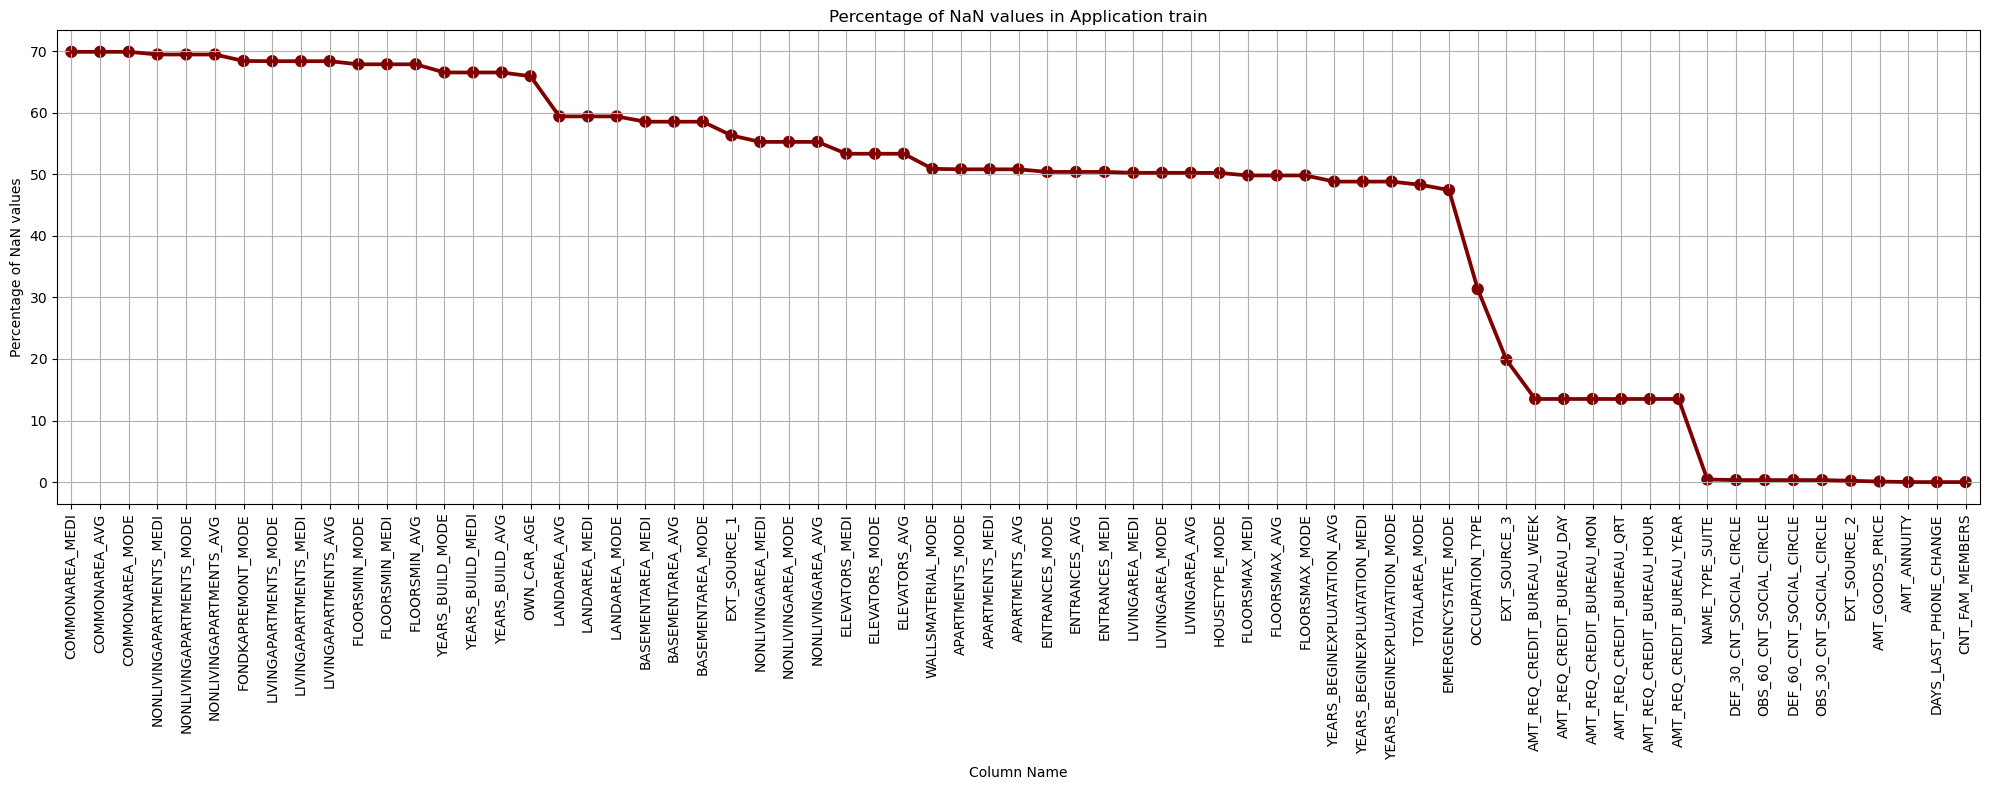

In [6]:
plot_missing_values_percent(application_train, 'Application train', grid = True)

<b> Nhận xét </b>
- Trong 123 features, có 67 features chứa các giá trị Nan. Trong đó gần 50 features chứa tỉ lệ missing lên đến hơn 50%. 
- Một quan sát thú vị khác rằng hầu như những feature chứa tỉ lệ missing cao đều liên quan đến căn hộ của người đi vay
- Với một số lượng lớn feature chứa các giá trị nan, chúng ta không thể drop hết tất cả các feature mà phải lựa chọn những kĩ thuật xử lý missing value hợp lý. Ở đây nhóm 12 lựa chọn drop cho các cột có giá trị missing trên 60% và fill nan bằng mean method cho biến numerical, và mode method cho biến categorical

In [7]:
count_missing_values(application_test)

Your data frame has 122 columns.
There are 66 columns that have missing values.


,total_nan,percent_nan
COMMONAREA_MEDI,42935,69.810738
COMMONAREA_AVG,42935,69.810738
COMMONAREA_MODE,42935,69.810738
NONLIVINGAPARTMENTS_MEDI,42645,69.339208
NONLIVINGAPARTMENTS_MODE,42645,69.339208
...,...,...
OBS_30_CNT_SOCIAL_CIRCLE,216,0.351208
EXT_SOURCE_2,131,0.213001
AMT_GOODS_PRICE,54,0.087802
AMT_ANNUITY,2,0.003252


Your data frame has 122 columns.
There are 66 columns that have missing values.


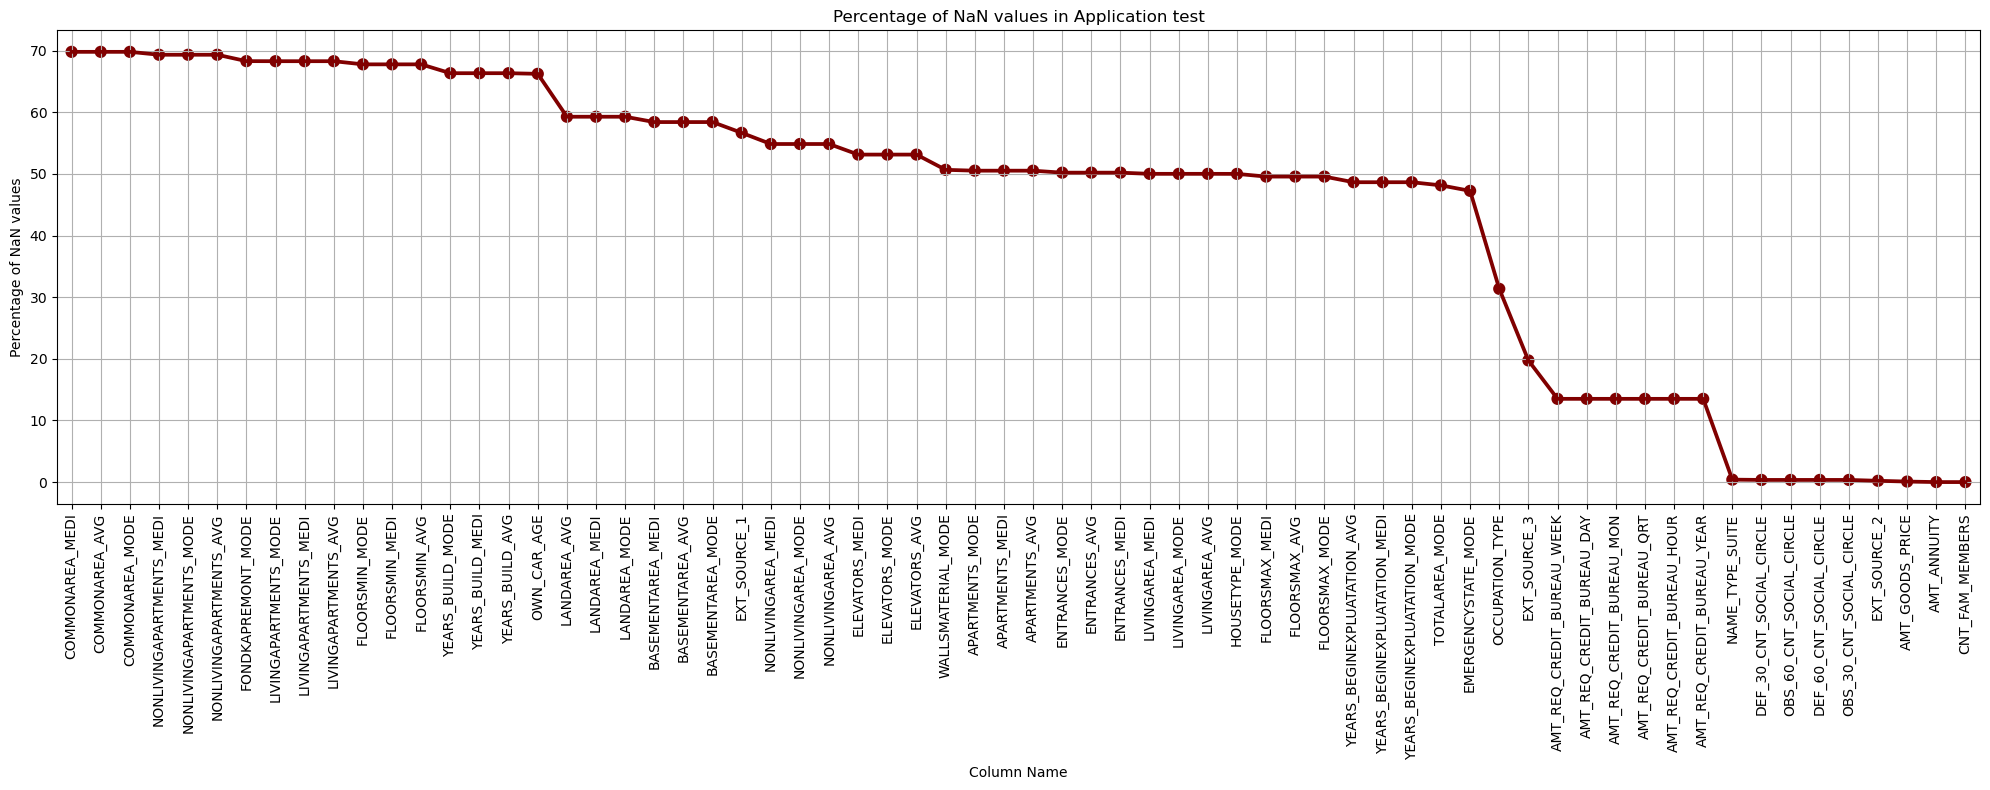

In [8]:
plot_missing_values_percent(application_test, 'Application test', grid = True)

<b> Nhận xét </b>
- Nhìn chung cũng giống với bảng application_train, application_test chứa 66 features chứa các giá trị nan, trong đó hơn 50 features có tỉ lệ missing trên 50%
- Ngoài ra, tỉ lệ phần trăm nan trong các cột cũng khá giống với tập train. Điều này phần nào cho thấy rằng tập dữ liệu train và tập dữ liệu test có mức phân bố khá giống nhau

### Imbalanced Data

In [9]:
application_train['TARGET'].value_counts()

TARGET
0    226133
1     19876
Name: count, dtype: int64

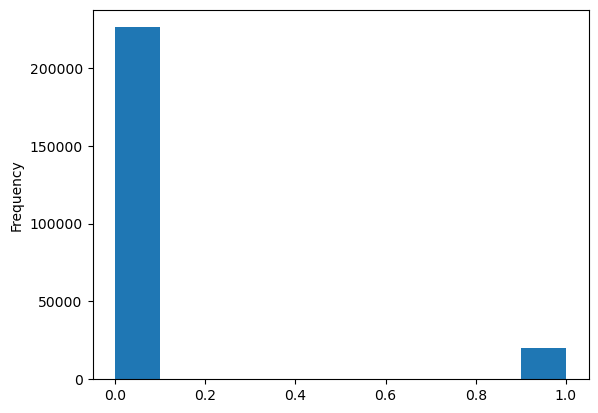

In [10]:
application_train['TARGET'].astype(int).plot.hist();

<b> Nhận xét </b>
- Chúng ta có thể thấy rằng tập dữ liệu bị mất cân bằng với số lượng mẫu mà khoản vay Non-Defaulter (TARGET=0) nhiều hơn 10 lần số lượng mẫu mà khoản vay Defaulter (TARGET=1). Chỉ có 8,07% tổng số khoản vay thực sự bị vỡ nợ. Điều này có nghĩa là Defaulters là tầng lớp thiểu số.
- Đây là lý do mà chúng ta lựa chọn metric ROC-AUC để đánh giá mô hình

### Examine Feature Correlations and Distribution

<b>1. Numerical Feature </b>

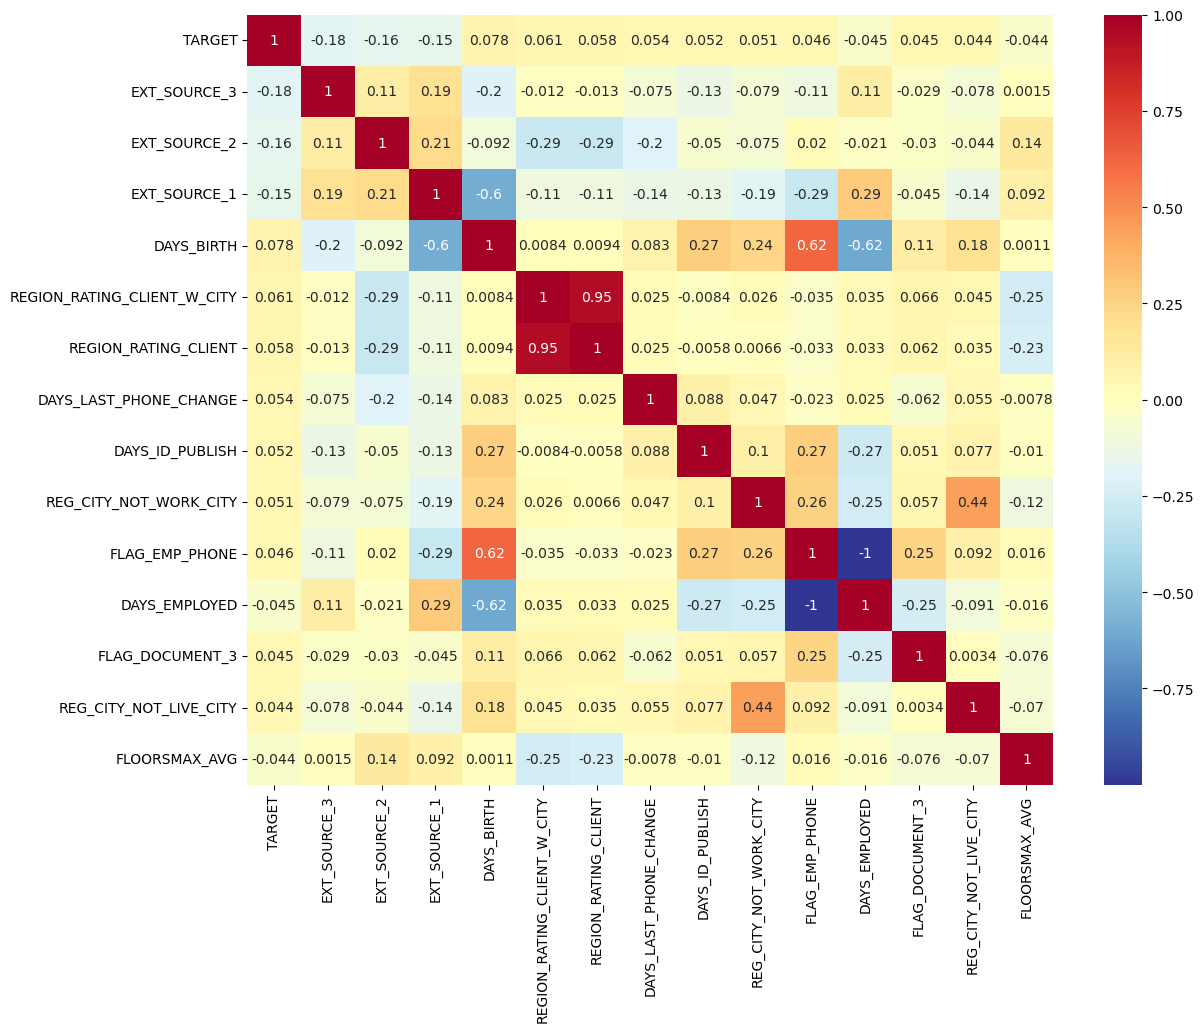

In [11]:
correlation_matrix(application_train, 15, numerical = True, categorical = False)

<b>Nhận xét</b>:
- Đây là top 15 những features có correlation cao nhất với biến 'TARGET'. Trong đó, các feature EX_SOURCE và DAYS_BIRTH là những feature có correlation cao nhất với biến 'TARGET'. Đây là thông tin quan trọng để chúng ta thực hiện quá trình Feature Engineering
- Chúng tôi cũng nhận thấy mối tương quan cao giữa DAYS_BIRTH và EX_SOURCE_1, DAY_EMPLOYED, DAY_ID_PUBLISH, REGION_RATING_CLIENT_W_CITY và REGION_RATING_CLIENT_. Để tránh hiện tượng multicolinear, chúng ta có thể cân nhắc drop các feature có tương quan lớn với nhau, hoặc thực hiện một số phép toán tử giữa các feature: cộng trừ nhân chia

- Đối với những biến chứa DAYS, chúng ta sẽ chuyển nó sang năm để có thể quan sát dễ dàng hơn

##### DAYS_BIRTH

In [12]:
application_train = create_day_to_year(application_train, ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH'], ['AGE', 'YEAR_EMPLOYED', 'YEAR_ID_PUBLISH'])

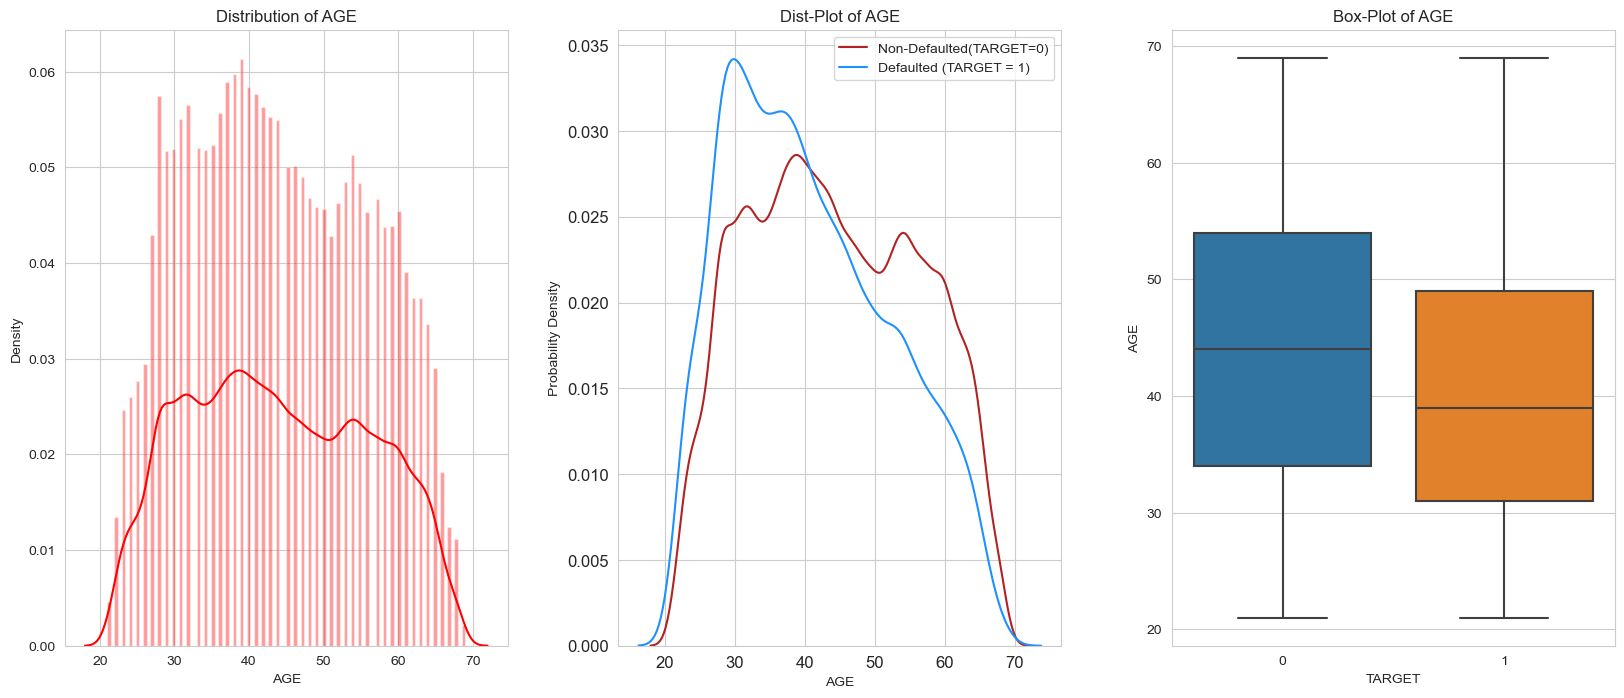

In [13]:
plot_numerical_variables(application_train,'AGE')

<b>Nhận xét</b>:
- Từ biểu đồ hist_plot: Dữ liệu có độ tuổi người vay năm trong khoảng từ hơn 20 tuổi đến gần 75 tuổi, tập trung nhiều ở khoảng từ 35 tuổi đến 45 tuổi. Điều này là hợp lý khi những người trong độ tuổi này có xu hướng vay tiền để kinh doanh, mua nhà và phục vụ cuộc sống,..
- Từ biểu đồ dist_plot: Độ tuổi có nhiều nợ xấu nhất là 30 tuổi. Biểu đồ phân bố độ tuổi giữa người nợ xấu và không nợ xấu cũng có sự khác nhau rõ ràng. Người trẻ có xu hướng nợ xấu nhiều hơn người già
- Từ biểu độ box_plot: Người trẻ có xu hướng nợ xấu nhiều hơn người lớn tuổi càng thể hiện rõ ở biểu đồ này khi tất cả quantiles của người nợ xấu đều nhỏ hơn người không nợ xấu

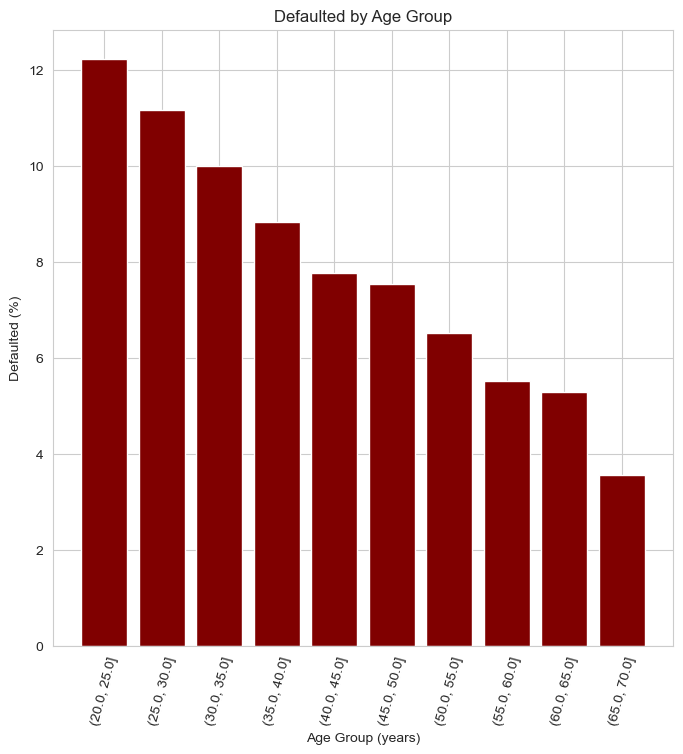

In [14]:
# Age information into a separate dataframe
age_data = application_train[['TARGET', 'AGE']]
# Bin the age data
age_data['AGE_BINNED'] = pd.cut(age_data['AGE'], bins = np.linspace(20, 70, num = 11))
age_groups  = age_data.groupby('AGE_BINNED').mean()

plt.figure(figsize = (8, 8))
# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'], color = 'maroon')

# Plot labeling
plt.xticks(rotation = 75); 
plt.xlabel('Age Group (years)'); 
plt.ylabel('Defaulted (%)')
plt.title('Defaulted by Age Group');

<b>Nhận xét</b>
- Điều này còn thể hiện rõ hơn khi chia tuổi người đi vay thành các nhóm.
- Từ đó cho thấy rằng việc chia AGE thành các bins cũng là một feature quan trọng đối với biến 'TARGET'
- Có thể tạo thêm các feature mới từ việc chia thành các bins

##### DAYS_EMPLOYED

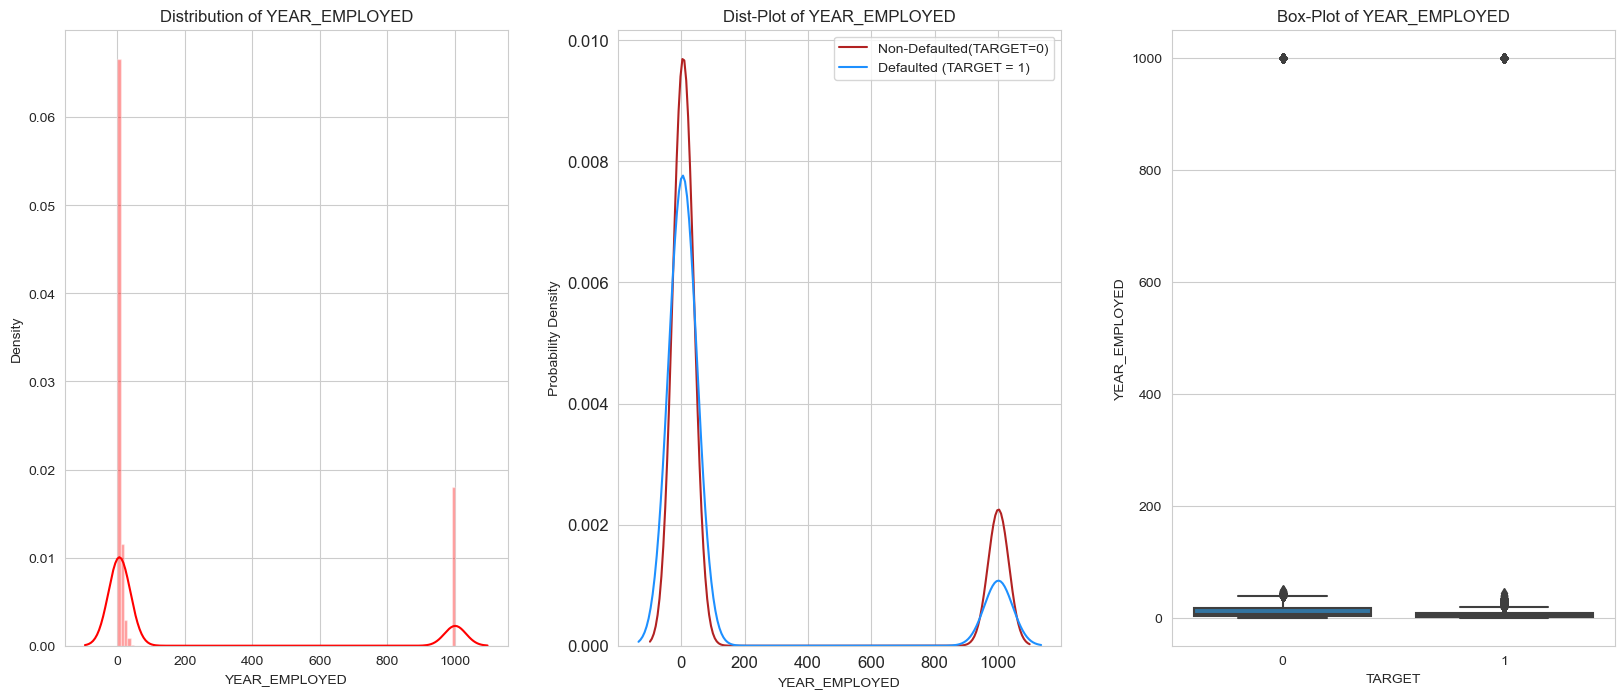

In [15]:
plot_numerical_variables(application_train,'YEAR_EMPLOYED')

<b>Nhận xét</b>
- Dựa vào biểu đồ, ta thấy feature YEAR_EMPLOYED chứa những giá trị bất thường 365243 tương đương gần 1000 năm. Điều này là vô lý, chúng ta có thể thay thế nó bằng các giá trị nan


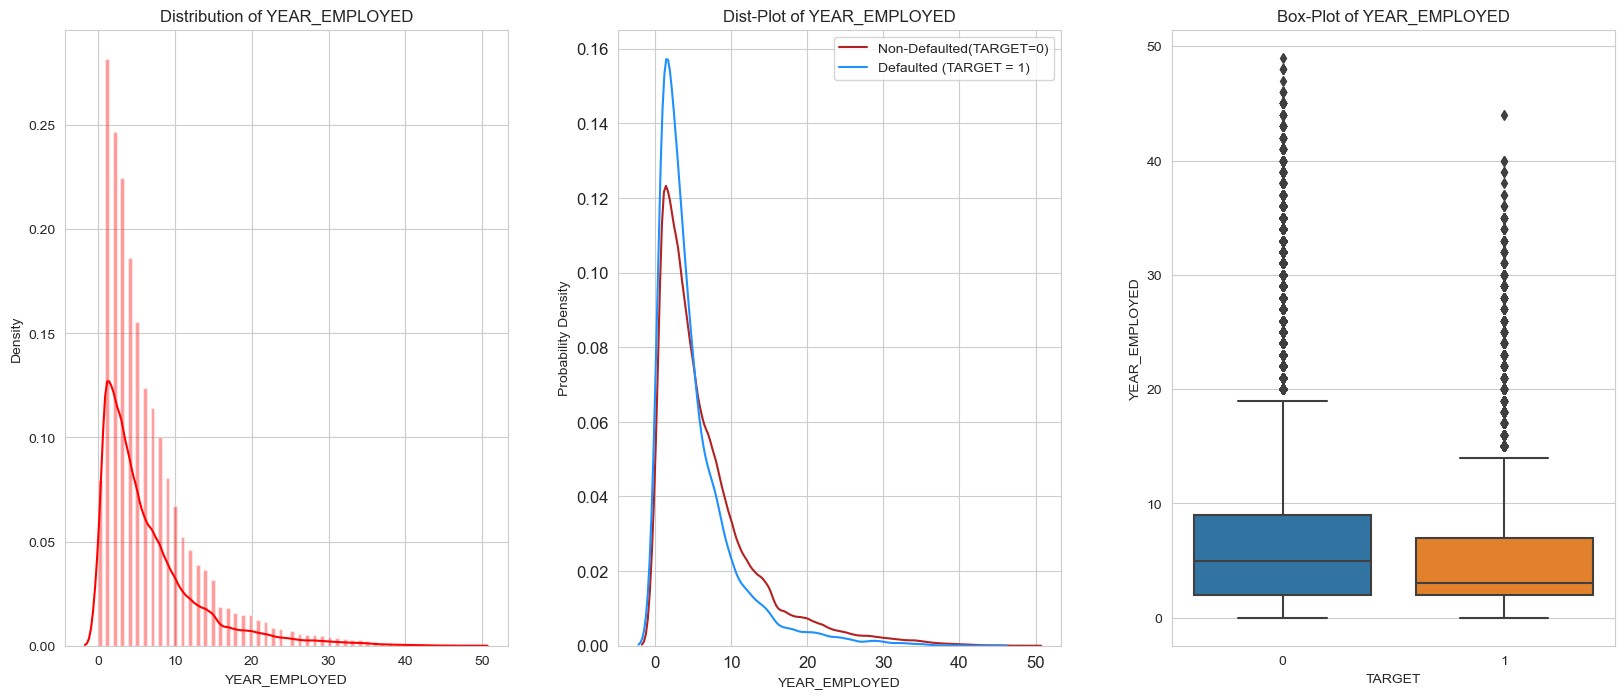

In [16]:
application_train['YEAR_EMPLOYED'][application_train['YEAR_EMPLOYED'] > 1000] = np.nan
plot_numerical_variables(application_train,'YEAR_EMPLOYED')

<b>Nhận xét</b>
- Sau khi loại bỏ các giá trị bất thường, nhìn vào biểu đồ box-plot chúng ta thấy rằng dường như những người nợ xấu thường có số năm làm việc ít hơn với những người không nợ xấu khi tất cả quantiles của những người nợ xấu đều thấp hơn
- Ngoài ra, feature cũng chứa nhiều giá trị outliers

##### DAYS_ID_PUBLIC

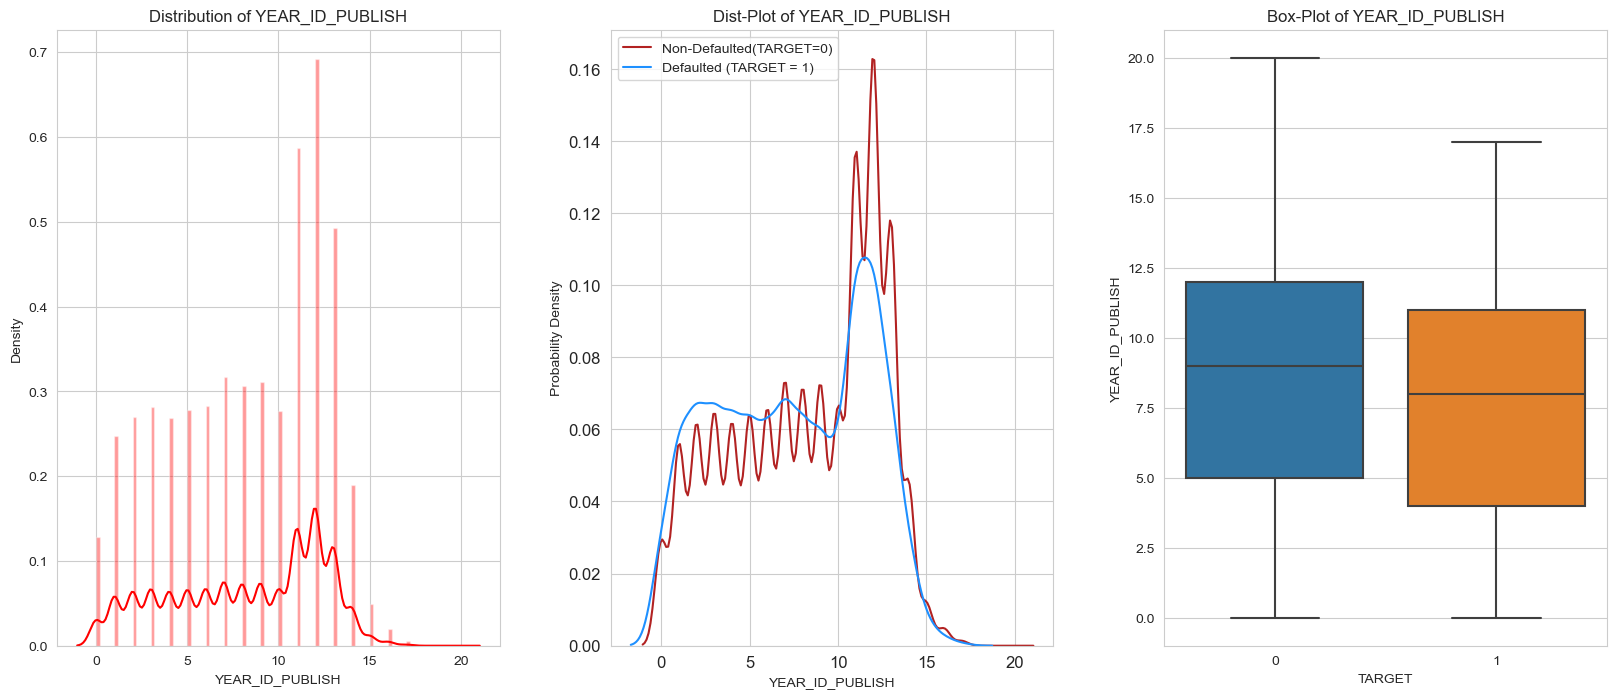

In [17]:
plot_numerical_variables(application_train,'YEAR_ID_PUBLISH')

<b>Nhận xét</b>:
- Nhìn vào biểu đồ box-plot, chúng ta có thể những người nợ xấu có số ngày thay đổi giấy tờ tùy thân cách ngày đăng ký lâu hơn những người không nợ xấu

##### EXT_SOURCES

----------------------------------------------------------------------------------------------------


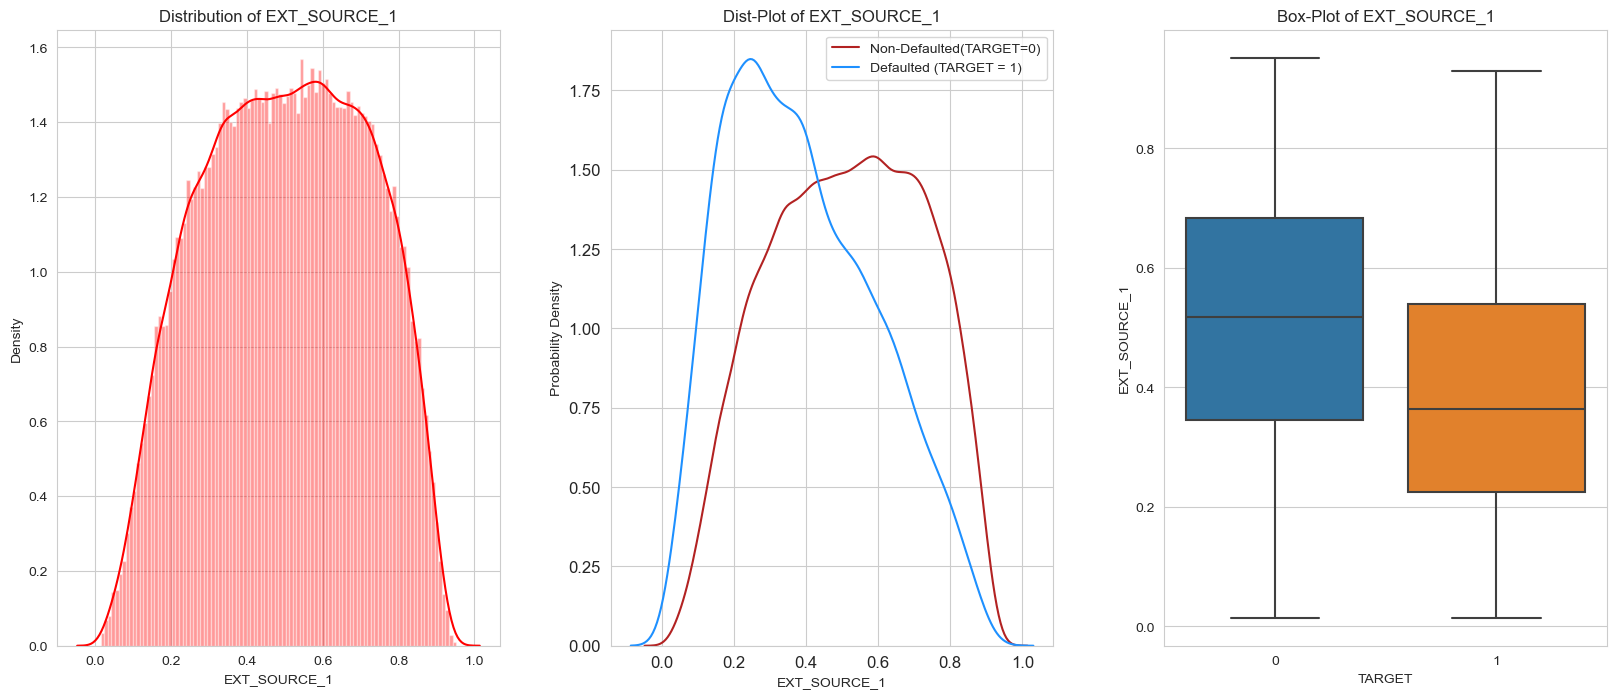

----------------------------------------------------------------------------------------------------


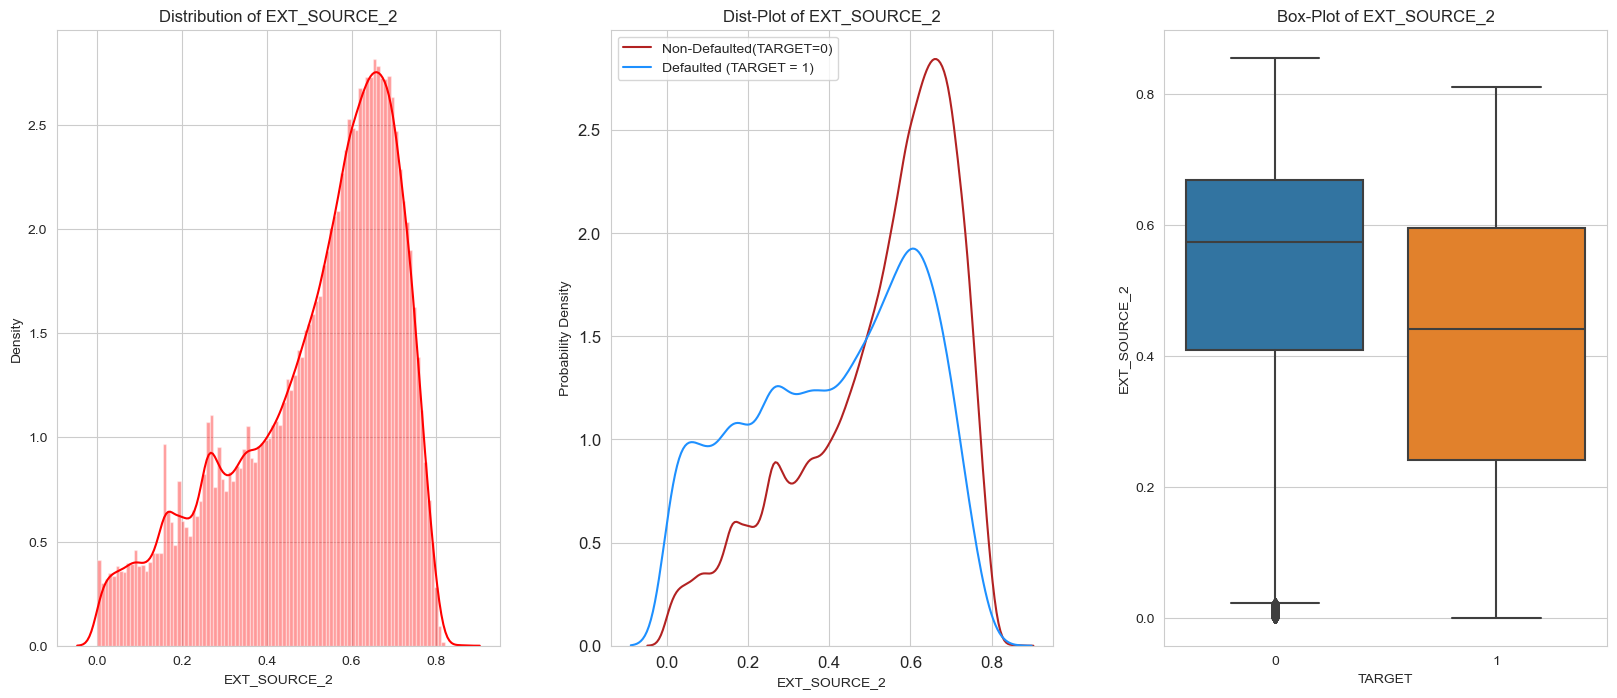

----------------------------------------------------------------------------------------------------


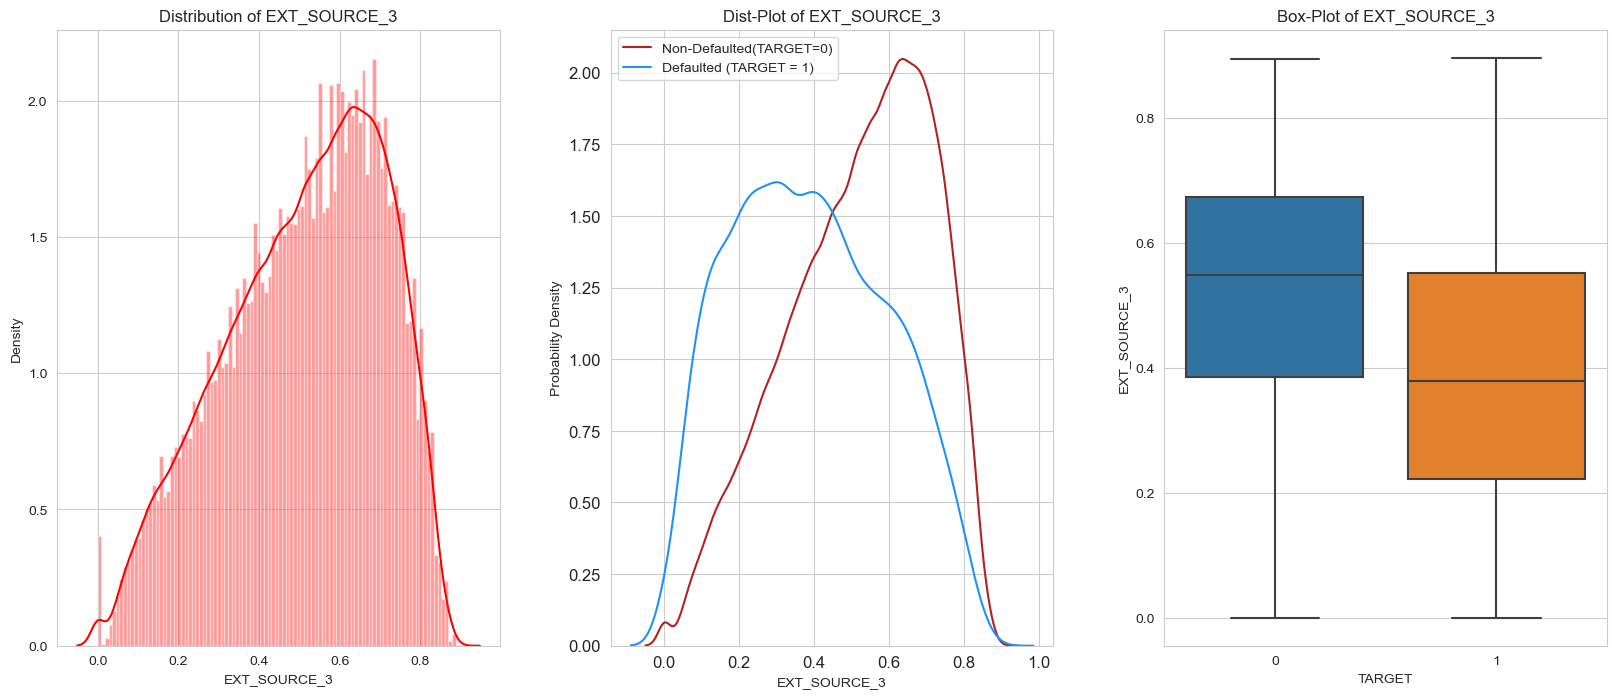

----------------------------------------------------------------------------------------------------


In [18]:
print('-'*100)
plot_numerical_variables(application_train,'EXT_SOURCE_1')
print('-'*100)
plot_numerical_variables(application_train,'EXT_SOURCE_2')
print('-'*100)
plot_numerical_variables(application_train,'EXT_SOURCE_3')
print('-'*100)

<b>Nhận xét</b>
- Nhìn vào biểu đồ dist_plot có thể thấy phân bố của những người nợ xấu và những người không nợ xấu có sự khác biệt rõ rệt
- Trong đó các giá trị EXT_SOURCE của người nợ xấu có xu hướng thấp hơn đáng kể so với những người không nợ xấu
- Các features EXT_SOURCE thể hiện tính phân tách tuyến tính giữa người nợ xấu và không nợ xấu tương đối tốt. Trong đó EXT_SOURCE_1 và EXT_SOURCE_3 có xu hướng hiển thị khả năng phân biệt/phân tách tốt hơn so với EXT_SOURCE_2.
- Chúng ta sẽ dùng một số kĩ thuật feature engineering để tạo thêm một số feature từ các biến EXT_SOURCE

<b>2. Categorical Features</b>

interval columns not set, guessing: ['TARGET']
interval columns not set, guessing: ['TARGET']


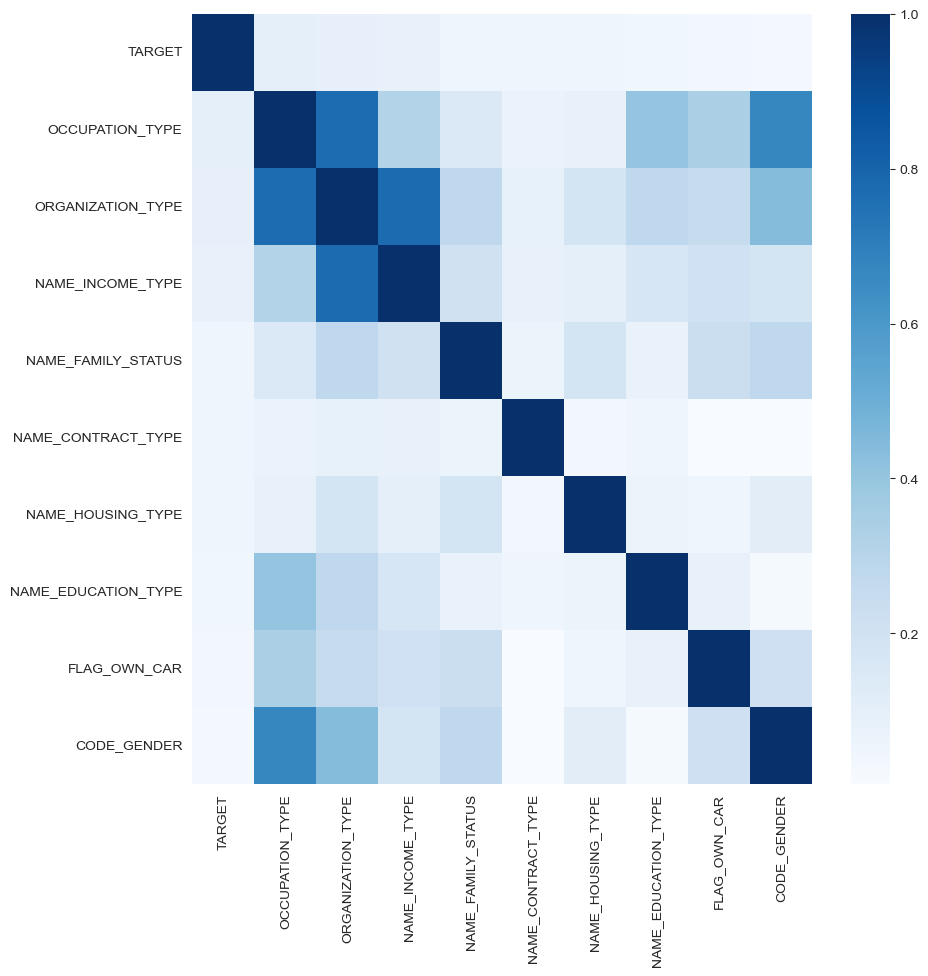

In [19]:
correlation_matrix(application_train, 10, numerical = False, categorical = True)

<b>Nhận xét</b>:
- Đây là top 10 những categorical features có correlation cao nhất với biến 'TARGET'. Trong đó, các feature OCCUPATION_TYPE, ORGANIZATION_TYPE, NAME_INCOME_TYPE và NAME_FAMILY_STATUS là những feature có correlation cao nhất với biến 'TARGET'. Đây là thông tin quan trọng để chúng ta thực hiện quá trình Feature Engineering
- Chúng tôi cũng nhận thấy mối tương quan cao giữa OCCUPATION_TYPE và ORGANIZATION_TYPE, CODE_GENDER, ORGANIZATION_TYPE và NAME_INCOME_TYPE. Để tránh hiện tượng multicolinear, chúng ta có thể cân nhắc drop các feature có tương quan lớn với nhau, hoặc thực hiện một số phép toán tử giữa các feature: cộng trừ nhân chia

##### OCCUPATION_TYPE

Total Number of unique categories of OCCUPATION_TYPE = 19


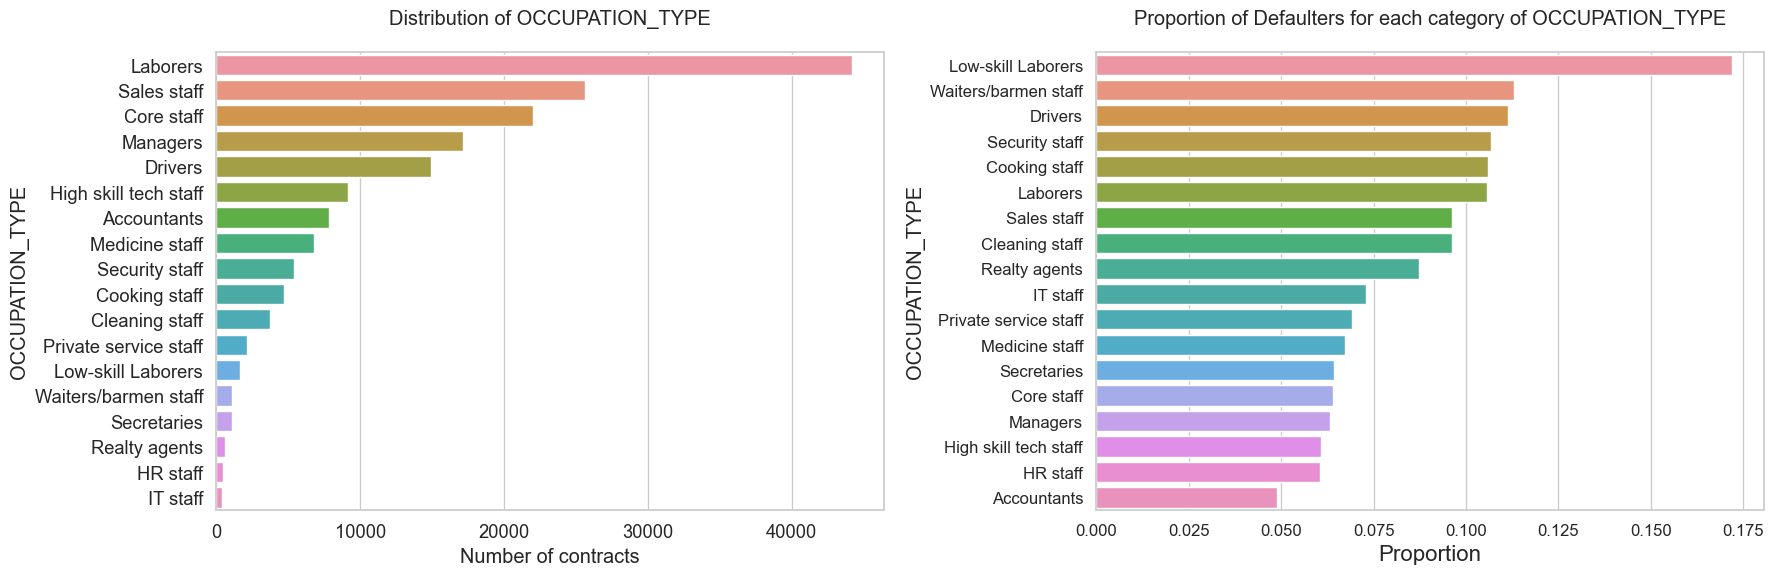

In [20]:
plot_categorical_variables(application_train, 'OCCUPATION_TYPE')

<b>Nhận xét</b>:
- Trong số những người đi vay, OCCUPATION_TYPE phổ biến nhất là Laborers, chiếm gần 26% số đơn đăng ký. Tiếp theo là Sales staff, Core staff and Managers.</li>
- Tỷ lệ vợ nỡ của lao động có trình độ thấp(Low-skill Laborers) là cao nhất trong số tất cả các loại nghề nghiệp (~17,5%). Tiếp theo là Waiter staff, Drivers, Security staff,.. Tất cả các công việc đều là công việc cấp thấp. Điều này cho thấy những người làm việc ở cấp độ thấp thường có tỷ lệ vỡ nợ cao hơn.
- Tỷ lệ vỡ nợ thấp nhất thuộc về Accountants, HR staff, High skill tech staff,... thuộc các công việc cấp trung đến cấp cao
- Như vậy có thể kết luận rằng người lao động làm việc ở trình độ thấp có xu hướng vỡ nợ cao hơn so với những công việc ở trình độ trung bình-cao.

##### NAME_EDUCATION_TYPE

Total Number of unique categories of NAME_EDUCATION_TYPE = 5


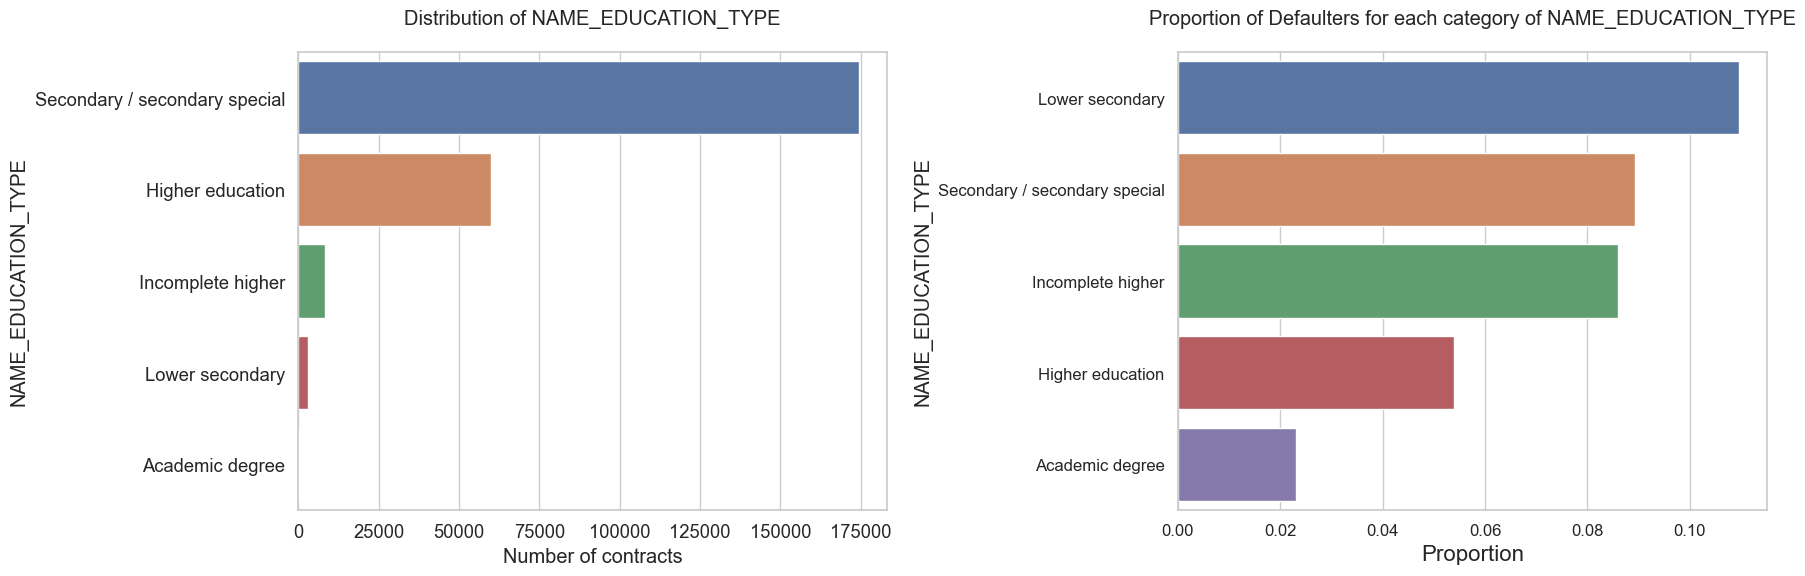

In [21]:
plot_categorical_variables(application_train, 'NAME_EDUCATION_TYPE')

<b>Nhận xét</b>:
- Những người có trình độ Secondary(/special) là chiếm nhiều nhất những người đi vay (hơn 70%). Tiếp theo là Higher education. Điều này cho thấy hầu hết người vay không có trình độ học vấn cao.
- Từ biểu đồ hai, chúng ta thấy rằng những người chỉ có Lower secondary có tỉ lệ nợ xấu có tỉ lệ cao nhất, tiếp đó là Secondary/Secondary-special.
- Nhóm người có trình độ học vấn cao hơn có xu hướng vỡ nợ tương đối thấp hơn, điều này cũng hợp lý.

##### NAME_FAMILY_STATUS

Total Number of unique categories of NAME_FAMILY_STATUS = 6


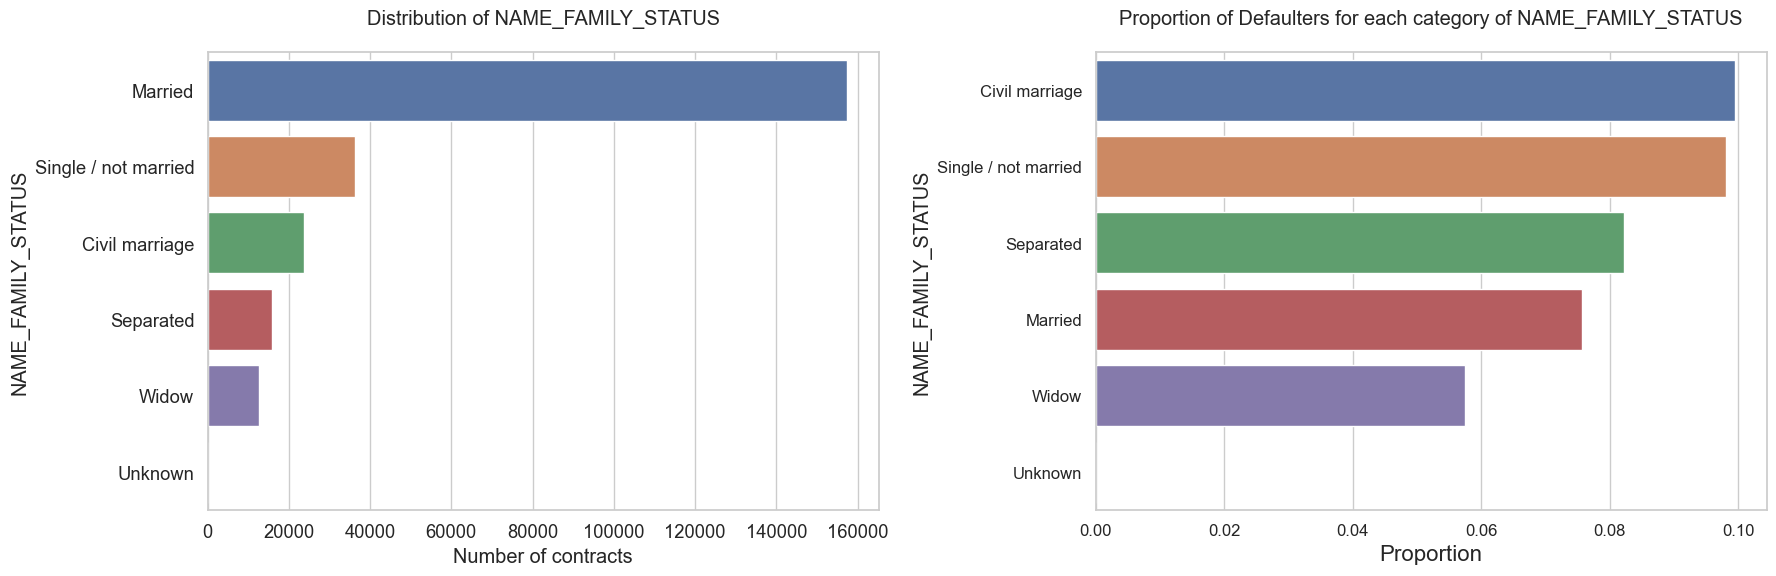

In [22]:
plot_categorical_variables(application_train, 'NAME_FAMILY_STATUS')

<b>Nhận xét</b>:
- Những người có tình trạng hôn nhân Married chiếm nhiều nhất những người đi vay (hơn 70%). Tiếp theo là Sigle/not married 
- Từ biểu đồ hai, chúng ta thấy rằng những người Civil marriage và single/not married chiếm tỉ lệ vỡ nợ cao nhất

##### CODE_GENDER

Total Number of unique categories of CODE_GENDER = 3


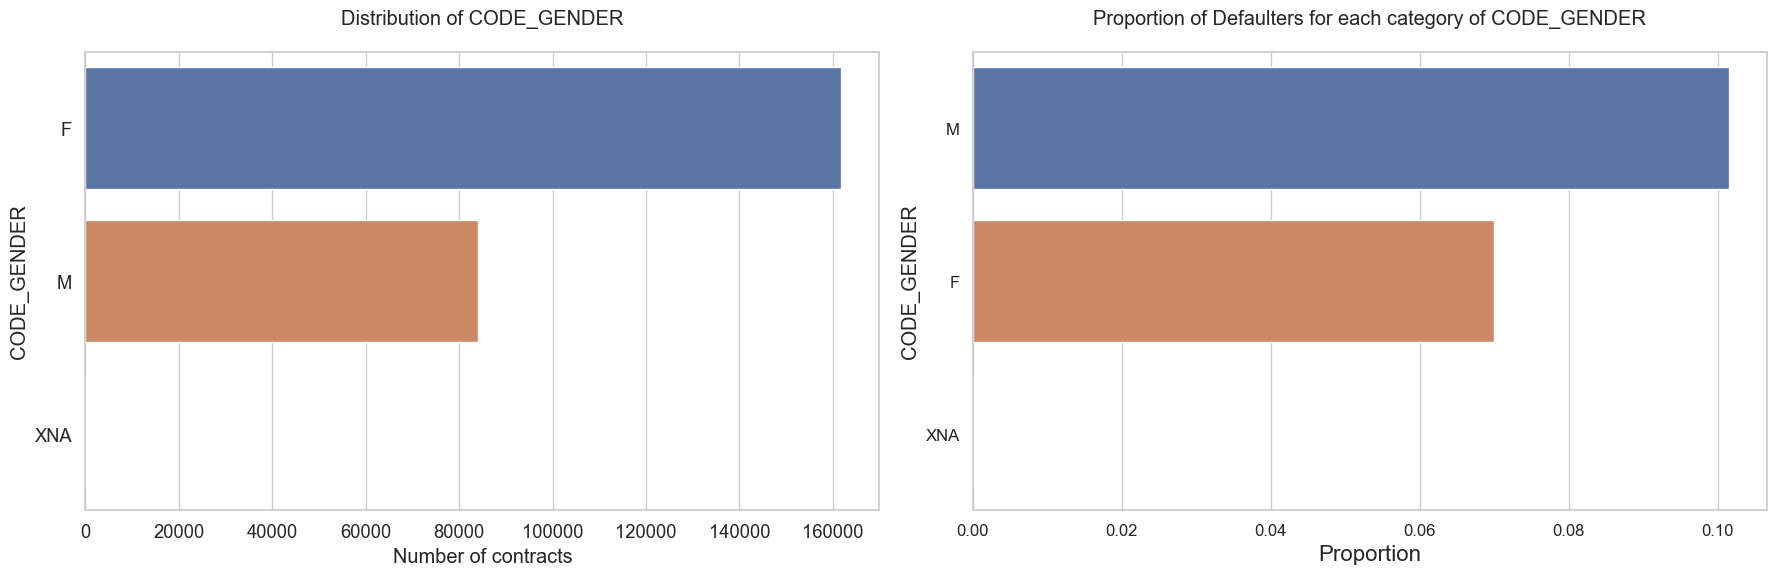

In [23]:
plot_categorical_variables(application_train, 'CODE_GENDER')

<b>Nhận xét</b>:
- Phụ nữ có xu hướng vay nhiều hơn đàn ông trong khi đàn ông có xu hướng nợ xấu nhiều hơn phụ nữ
- Ngoài ra CODE-GENDER cũng chứa một số giá trị không xác định XNA. Chúng ta có thể thay thế nó bằng các giá trị nan

### NEW FEATURE

Như đã phân tích những features EXT_SOURCE là những feature có khả năng phân tách tốt nhất giữa người nợ xấu và không nợ xấu. Chính vì thế, nhóm 12 lựa chọn một số phép biến đổi với biến EXT_SOURCE. Ngoài ra feature AGE là một feature quan trọng khác


In [24]:
#EXT_SOURCES
application_train['EXT_SOURCE_MEAN'] = (application_train['EXT_SOURCE_1'] + application_train['EXT_SOURCE_2'] + application_train['EXT_SOURCE_3'] ) / 3
application_train['EXT_SOURCE_MUL'] = application_train['EXT_SOURCE_1'] * application_train['EXT_SOURCE_2'] * application_train['EXT_SOURCE_3'] 
application_train['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(application_train['EXT_SOURCE_1'], application_train['EXT_SOURCE_2'], application_train['EXT_SOURCE_3'])]
application_train['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(application_train['EXT_SOURCE_1'], application_train['EXT_SOURCE_2'], application_train['EXT_SOURCE_3'])]
application_train['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(application_train['EXT_SOURCE_1'], application_train['EXT_SOURCE_2'], application_train['EXT_SOURCE_3'])]
application_train['WEIGHTED_EXT_SOURCE'] =  application_train['EXT_SOURCE_1'] * 2 + application_train['EXT_SOURCE_2'] * 3 + application_train['EXT_SOURCE_3'] * 4

# AGE
application_train['AGE_EMPLOYED_DIFF'] = application_train['AGE'] - application_train['YEAR_EMPLOYED']
application_train['CAR_EMPLOYED_DIFF'] = application_train['OWN_CAR_AGE'] - application_train['YEAR_EMPLOYED']
application_train['CAR_AGE_DIFF'] = application_train['AGE'] - application_train['OWN_CAR_AGE']

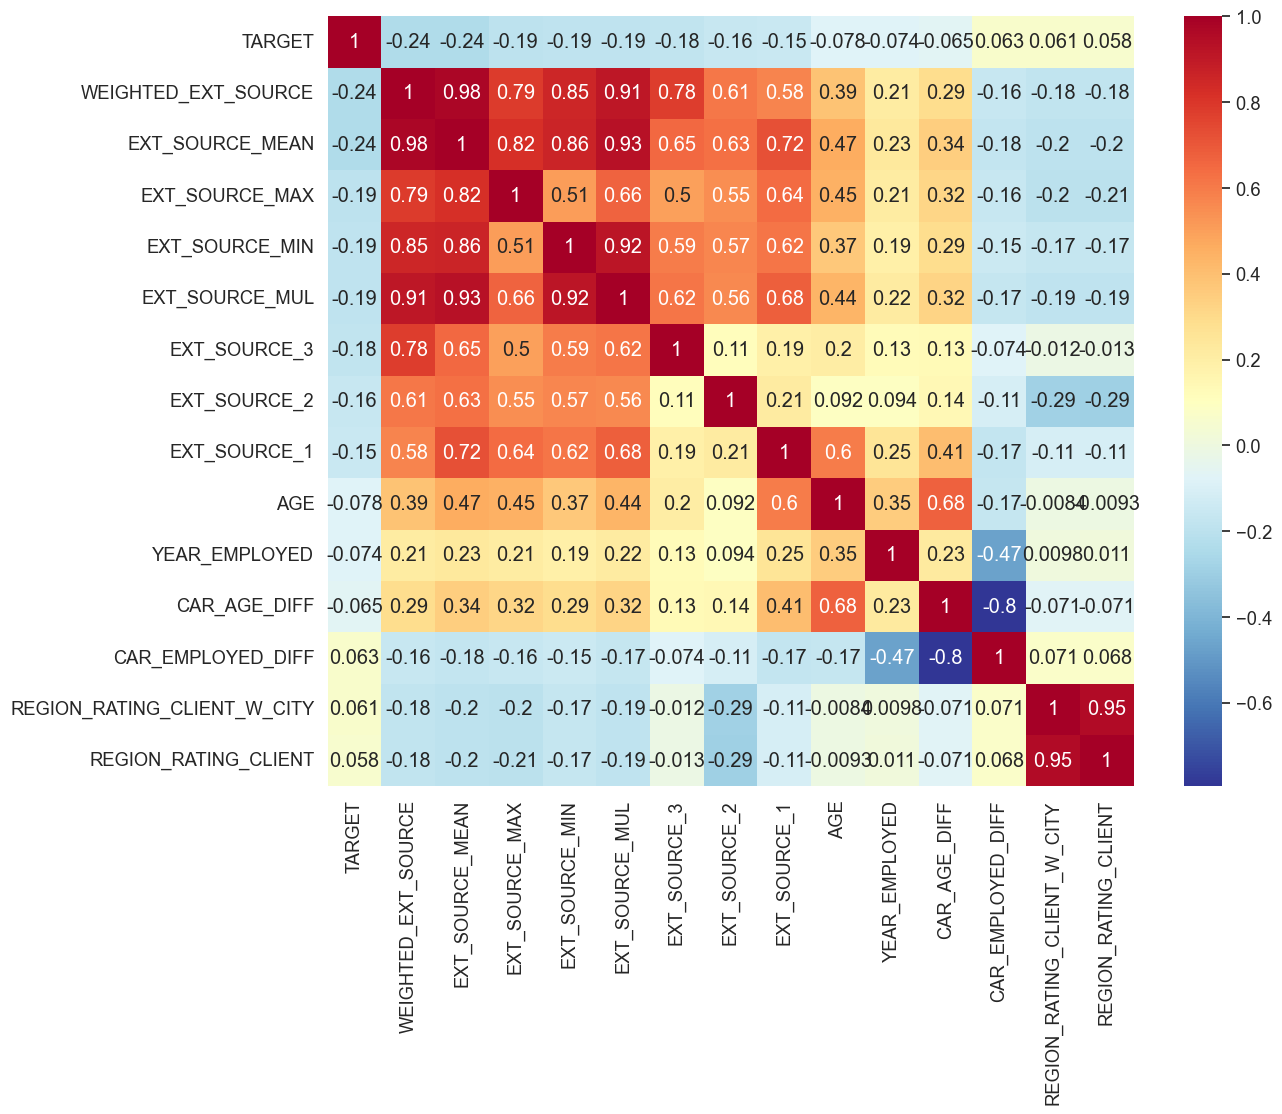

In [25]:
correlation_matrix(application_train, 15, numerical = True, categorical = False)

<b>Nhận xét</b>:
- Có thể thấy những features mới được tạo thành có correlation rất cao với biến TARGET